### **IMPORTS**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import plotly.graph_objects as go

R_J = 0.91  # From Yuan et al. 2013
R_K = 0.39

### **LOADING IN THE DATA**

In [2]:
file = open('distance_color_type_for_all_stars.txt', 'r')
file_csv = open('distance_color_type_for_all_stars_csv.csv', 'w')

header = [
    'ASASSN_id', 'distance', 'distance_low', 'distance_high', 'g_mag', 'Gaia_name', 'G_mag', 'G_mag_err',
    'abs_mag_G', 'abs_mag_G_low', 'abs_mag_G_high', 'ext_correct_G', 'ext_correct_G_low', 'ext_correct_G_high',
    'BP_RP', 'BP_RP_err', 'BP_RP_0', 'BP_RP_0_err', 'J_mag', 'J_mag_err', 'K_mag', 'K_mag_err',
    'abs_mag_J', 'abs_mag_J_low', 'abs_mag_J_high', 'ext_correct_J', 'ext_correct_J_low', 'ext_correct_J_high',
    'ext_correct_K', 'ext_correct_K_low', 'ext_correct_K_high', 'FinalType', 'ML_classifier_type',
    'visual_classification_type', 'VSX_type', 'VSX_RA', 'VSX_Dec', 'VSX_name'
]

file_csv.write(','.join(header) + '\n')

lines = file.readlines()
for line in lines:
    line_split = line.split()
    
    # Remove the first 'ASASSN' entry
    if line_split[0] == 'ASASSN':
        line_split = line_split[1:]
    
    cleaned_data = []
    for item in line_split:
        if '=' in item:
            continue  # Skip items with '='
        cleaned_data.append(item)
    
    # Combine Gaia_name into a single string
    gaia_start = 5  # Adjusted index where Gaia_name starts after removing 'ASASSN'
    gaia_end = 8    # Adjusted index where Gaia_name ends
    gaia_name = ' '.join(cleaned_data[gaia_start:gaia_end])
    cleaned_data = cleaned_data[:gaia_start] + [gaia_name] + cleaned_data[gaia_end:]
    
    # Combine VSX_name into a single string
    vsx_name_start = 37  # Adjusted index where VSX_name starts
    vsx_name = ' '.join(cleaned_data[vsx_name_start:])
    cleaned_data = cleaned_data[:vsx_name_start] + [vsx_name]

    all_letters = set(string.ascii_letters)
    if any(letter in all_letters for letter in cleaned_data[35]):
        continue
    
    file_csv.write(','.join(cleaned_data) + '\n')

file.close()
file_csv.close()

In [3]:
color_csv = pd.read_csv('distance_color_type_for_all_stars_csv.csv')

### **FILTERING & ERROR CALCULATIONS**

In [4]:
clean_final = color_csv[(color_csv["distance"] < 99998) & (color_csv["K_mag"].between(1, 99.998, inclusive='neither'))].copy()
    # filtering distances and magnitudes that did not have real values in the original data 

clean_final["J-K"] = clean_final["J_mag"] - clean_final["K_mag"]
    # creating a new column for the J-K color

clean_final = clean_final[clean_final["J-K"] > -1]
    # filtering J-K colors that are not high enough

In [5]:
errors = clean_final[((clean_final["distance_high"] - clean_final["distance_low"]) / clean_final["distance"]) < 0.3].copy()
    # filtering out stars that have too high of an error value in the distance. current value is that the error must be lower than 30%

In [6]:
# COLOR ERROR PROPOGATION
errors['J-K_err'] = np.sqrt(errors['J_mag_err']**2 + errors['K_mag_err']**2)
    # when two measurements are subtracted (like J-K), the variance of the result is the sum of the variances, given by the equation sigma_J-K = sqrt(sigma_J^2 + sigma_K^2)


# DISTANCE UNCERTAINTY
errors['sigma_distance'] = (errors['distance_high'] - errors['distance_low']) / 2
errors['sigma_dist_term'] = (5/np.log(10)) * (errors['sigma_distance']/errors['distance'])
    # calculating uncertainty in distance modulus due to error in distance
    # the distance modulus is given by the equation mu = 5log_10(d) - 5
    # its error propagation gives sigma_mu = |d mu / d d| * sigma_d = (5 / ln(10)) * (sigma_d / d)


# CALCULATE E(B-V) VALUE FROM EXTINCTION
errors['E(B-V)'] = errors['ext_correct_J'] / R_J  # A_J = R_J * E(B-V) => E(B-V) = A_J/R_J
    # we have the extinction in the J-band and want to infer the underlying reddening, which is useful for dereddening stars and comparing extinction-corrected magnitudes
    # we can use the equation A_J = R_J * E(B-V) -> E(B-V) = (A_J / R_J)


# CALCULATE A_J AND E(J-K) FROM E(B-V)
errors['A_J'] = R_J * errors['E(B-V)']
errors['E(J-K)'] = (R_J - R_K) * errors['E(B-V)']
    # very similar to previous step, using E(J-K) = A_J - A_K = (R_J - R_K) * E(B-V)


# ABSOLUTE MAGNITUDE VALUES CORRECTED FOR EXTINCTION
errors['abs_mag_J'] = (errors['J_mag'] - 5 * np.log10(errors['distance']) + 5 - errors['A_J'])
    # M_J = m_J - 5log_10(d) + 5 - A_J

errors['abs_mag_J_err'] = np.sqrt(errors['J_mag_err']**2 + errors['sigma_dist_term']**2 + (R_J * 0.1  * errors['E(B-V)'])**2) #assuming 10% error
    # sigma_MJ^2 = sigma_mJ^2 + sigma_mu^2 + sigma_AJ^2
    # again, ASSUMING 10% ERROR ---- CHECK!!! COULD BE INACCURATE
    # if we do have errors on extinction values or E(B–V), we could replace the 0.1 * E(B-V) with the actual uncertainty


# QUALITY CUTS
filtered = errors[(errors['J-K_err'] < 0.15) & (errors['abs_mag_J_err'] < 0.30) & (errors['E(J-K)'] < 0.30) & (errors['A_J'] < 3.0)]
    # attempting to keep "high-quality" stars with:
        # low color error
        # low absolute magnitude error
        # low reddening
        # low extinction
    # these thresholds CAN BE ADJUSTED and SHOULD BE TINKERED AROUND WITH TO FIND THE BEST VALUES

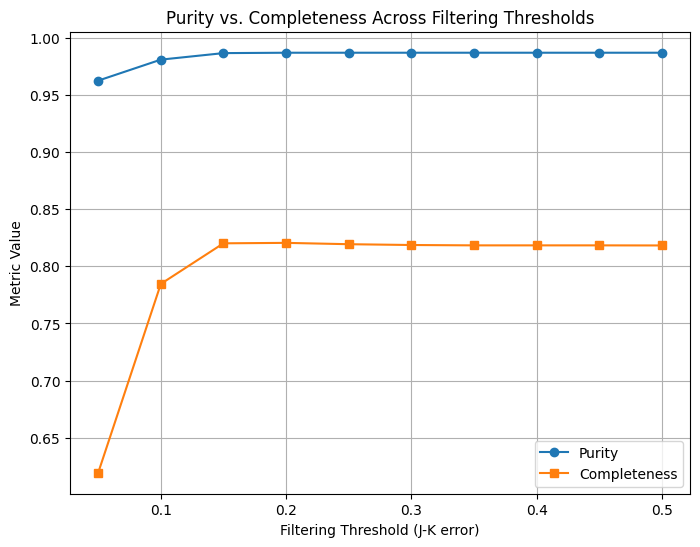

In [7]:
thresholds = np.linspace(0.05, 0.5, 10)
purity_list = []
completeness_list = []

rr_types = ['RRAB', 'RRC', 'RR(B)']
non_rr_types = ['EB', 'EW', 'DSCT']

for t in thresholds:
    subset = errors[
        (errors['J-K_err'] < t) &
        (errors['abs_mag_J_err'] < t * 2) &
        (errors['E(J-K)'] < t * 2) &
        (errors['A_J'] < 3.0)
    ]

    # Define the RR region
    in_region = (subset['J-K'] > 0.05) & (subset['J-K'] < 0.60) & \
                (subset['abs_mag_J'] > -0.9) & (subset['abs_mag_J'] < 0.8)

    rr_in_region = subset[(subset['FinalType'].isin(rr_types)) & in_region]
    rr_out_region = subset[(subset['FinalType'].isin(rr_types)) & (~in_region)]
    non_rr_in_region = subset[(subset['FinalType'].isin(non_rr_types)) & in_region]

    TP = len(rr_in_region)
    FP = len(non_rr_in_region)
    FN = len(rr_out_region)

    purity = TP / (TP + FP) if (TP + FP) > 0 else 0
    completeness = TP / (TP + FN) if (TP + FN) > 0 else 0

    purity_list.append(purity)
    completeness_list.append(completeness)

# Plotting the results
plt.figure(figsize=(8,6))
plt.plot(thresholds, purity_list, marker='o', label='Purity')
plt.plot(thresholds, completeness_list, marker='s', label='Completeness')
plt.xlabel("Filtering Threshold (J-K error)")
plt.ylabel("Metric Value")
plt.title("Purity vs. Completeness Across Filtering Thresholds")
plt.legend()
plt.grid(True)
plt.show()


In [8]:
filtered["FinalType"].unique()

array(['RRAB', 'RRC', 'CONSTANT', 'NO', 'EB', 'EW', 'RR(B)', 'BY', 'EA',
       'SRA', 'RS', 'SRB', 'L', 'SXPHE', 'SR', 'GDOR:', 'DSCT', 'GDOR',
       'DCEP', 'CWA:', 'BY:', 'LPV_MIRA_AGB_C', 'BY+UV', 'CEP', 'L:',
       'CEPH', 'IN'], dtype=object)

In [9]:
unwanted_types = ["BY", "SRA", "CONSTANT", "RS", "L", "SXPHE", "SR", "GDOR", "NO", "DCEP", "CWA:", "BY:", "LPV_MIRA_AGB_C", "BY+UV", "GDOR:", "CEP", "L:", "CEPH"]
    # creating a list of the type classifications that we do not want included in certain graphs and value calculations
wanted_types = filtered[~filtered["FinalType"].isin(unwanted_types)]
wanted_types["FinalType"].unique()

array(['RRAB', 'RRC', 'EB', 'EW', 'RR(B)', 'EA', 'SRB', 'DSCT', 'IN'],
      dtype=object)

one more round of filtering should be done to:
- define the "RR region"
- create a list of objects that are classified as RR in FinalType but OUTSIDE the RR region
- create a list of objects that are NOT classified as RR in FinalType but INSIDE the RR region

additionally, as commented above, various values of previous filtering should be tested to find the most optimal values for filtering

### **ANALYSIS**

In [10]:
# creating a data frame that has just one specific type of star for all of the remaining types of stars

RRAB = wanted_types[wanted_types["FinalType"] == "RRAB"]
RRC = wanted_types[wanted_types["FinalType"] == "RRC"]
EW = wanted_types[wanted_types["FinalType"] == "EW"]
EB = wanted_types[wanted_types["FinalType"] == "EB"]
RRB = wanted_types[wanted_types["FinalType"] == "RR(B)"]
DSCT = wanted_types[wanted_types["FinalType"] == "DSCT"]

In [11]:
# creating a list of RR objects that are outside of the RR region
# objects = RRAB, RRC, RRB
# region = 0.05 < J-K < 0.60 and -1.2 < abs_mag_J < 0.85

rr_types = ["RRAB", "RRC", "RR(B)"]
rr_objects = wanted_types[wanted_types["FinalType"].isin(rr_types)]
region_mask = (rr_objects["J-K"] > 0.05) & (rr_objects["J-K"] < 0.60) & (rr_objects["abs_mag_J"] > -1.2) & (rr_objects["abs_mag_J"] < 0.85)
RR_objects_outside_region = rr_objects[~region_mask]

# converting to a CSV file for further analysis
RR_objects_outside_region.to_csv('RR_objects_outside_rr_region.csv', index=False)

In [12]:
# creating a list of non-RR objects that are inside the RR region
# objects = EW, EB, DSCT
# region = 0.05 < J-K < 0.60 and -1.2 < abs_mag_J < 0.85

non_rr_types = ["EW", "EB", "DSCT"]
non_rr_objects = wanted_types[wanted_types["FinalType"].isin(non_rr_types)]
region_mask_non_rr = (non_rr_objects["J-K"] > 0.05) & (non_rr_objects["J-K"] < 0.60) & (non_rr_objects["abs_mag_J"] > -1.2) & (non_rr_objects["abs_mag_J"] < 0.85)
non_RR_objects_inside_region = non_rr_objects[region_mask_non_rr]

# converting to a CSV file for further analysis
non_RR_objects_inside_region.to_csv('non_RR_objects_inside_rr_region.csv', index=False)

In [13]:
# creating a mask for the region of interest
in_region = ((wanted_types['J-K'] > 0.05) & (wanted_types['J-K'] < 0.60) & (wanted_types['abs_mag_J'] > -1.2) & (wanted_types['abs_mag_J'] < 0.85))

# applying the mask to filter the DataFrame
correct_data = wanted_types[((wanted_types['FinalType'].isin(rr_types)) & in_region) | ((wanted_types['FinalType'].isin(non_rr_types)) & (~in_region))]

In [14]:
# checking how many objects are in the correct data
print(f"Number of objects in the correct data: {len(correct_data)}")

# checking how many objects are in the incorrect spots
print(f"Number of objects in the incorrect spots: {len(wanted_types) - len(correct_data)}")

# checking how many objects there are total
print(f"Total number of objects: {len(wanted_types)}")

Number of objects in the correct data: 8472
Number of objects in the incorrect spots: 1762
Total number of objects: 10234


### **GRAPHS & FIGURES**

In [15]:
# creating a data frame that has just one specific type of star for all of the remaining types of stars

RRAB = correct_data[correct_data["FinalType"] == "RRAB"]
RRC = correct_data[correct_data["FinalType"] == "RRC"]
EW = correct_data[correct_data["FinalType"] == "EW"]
EB = correct_data[correct_data["FinalType"] == "EB"]
RRB = correct_data[correct_data["FinalType"] == "RR(B)"]
DSCT = correct_data[correct_data["FinalType"] == "DSCT"]

(7.0, -3.0)

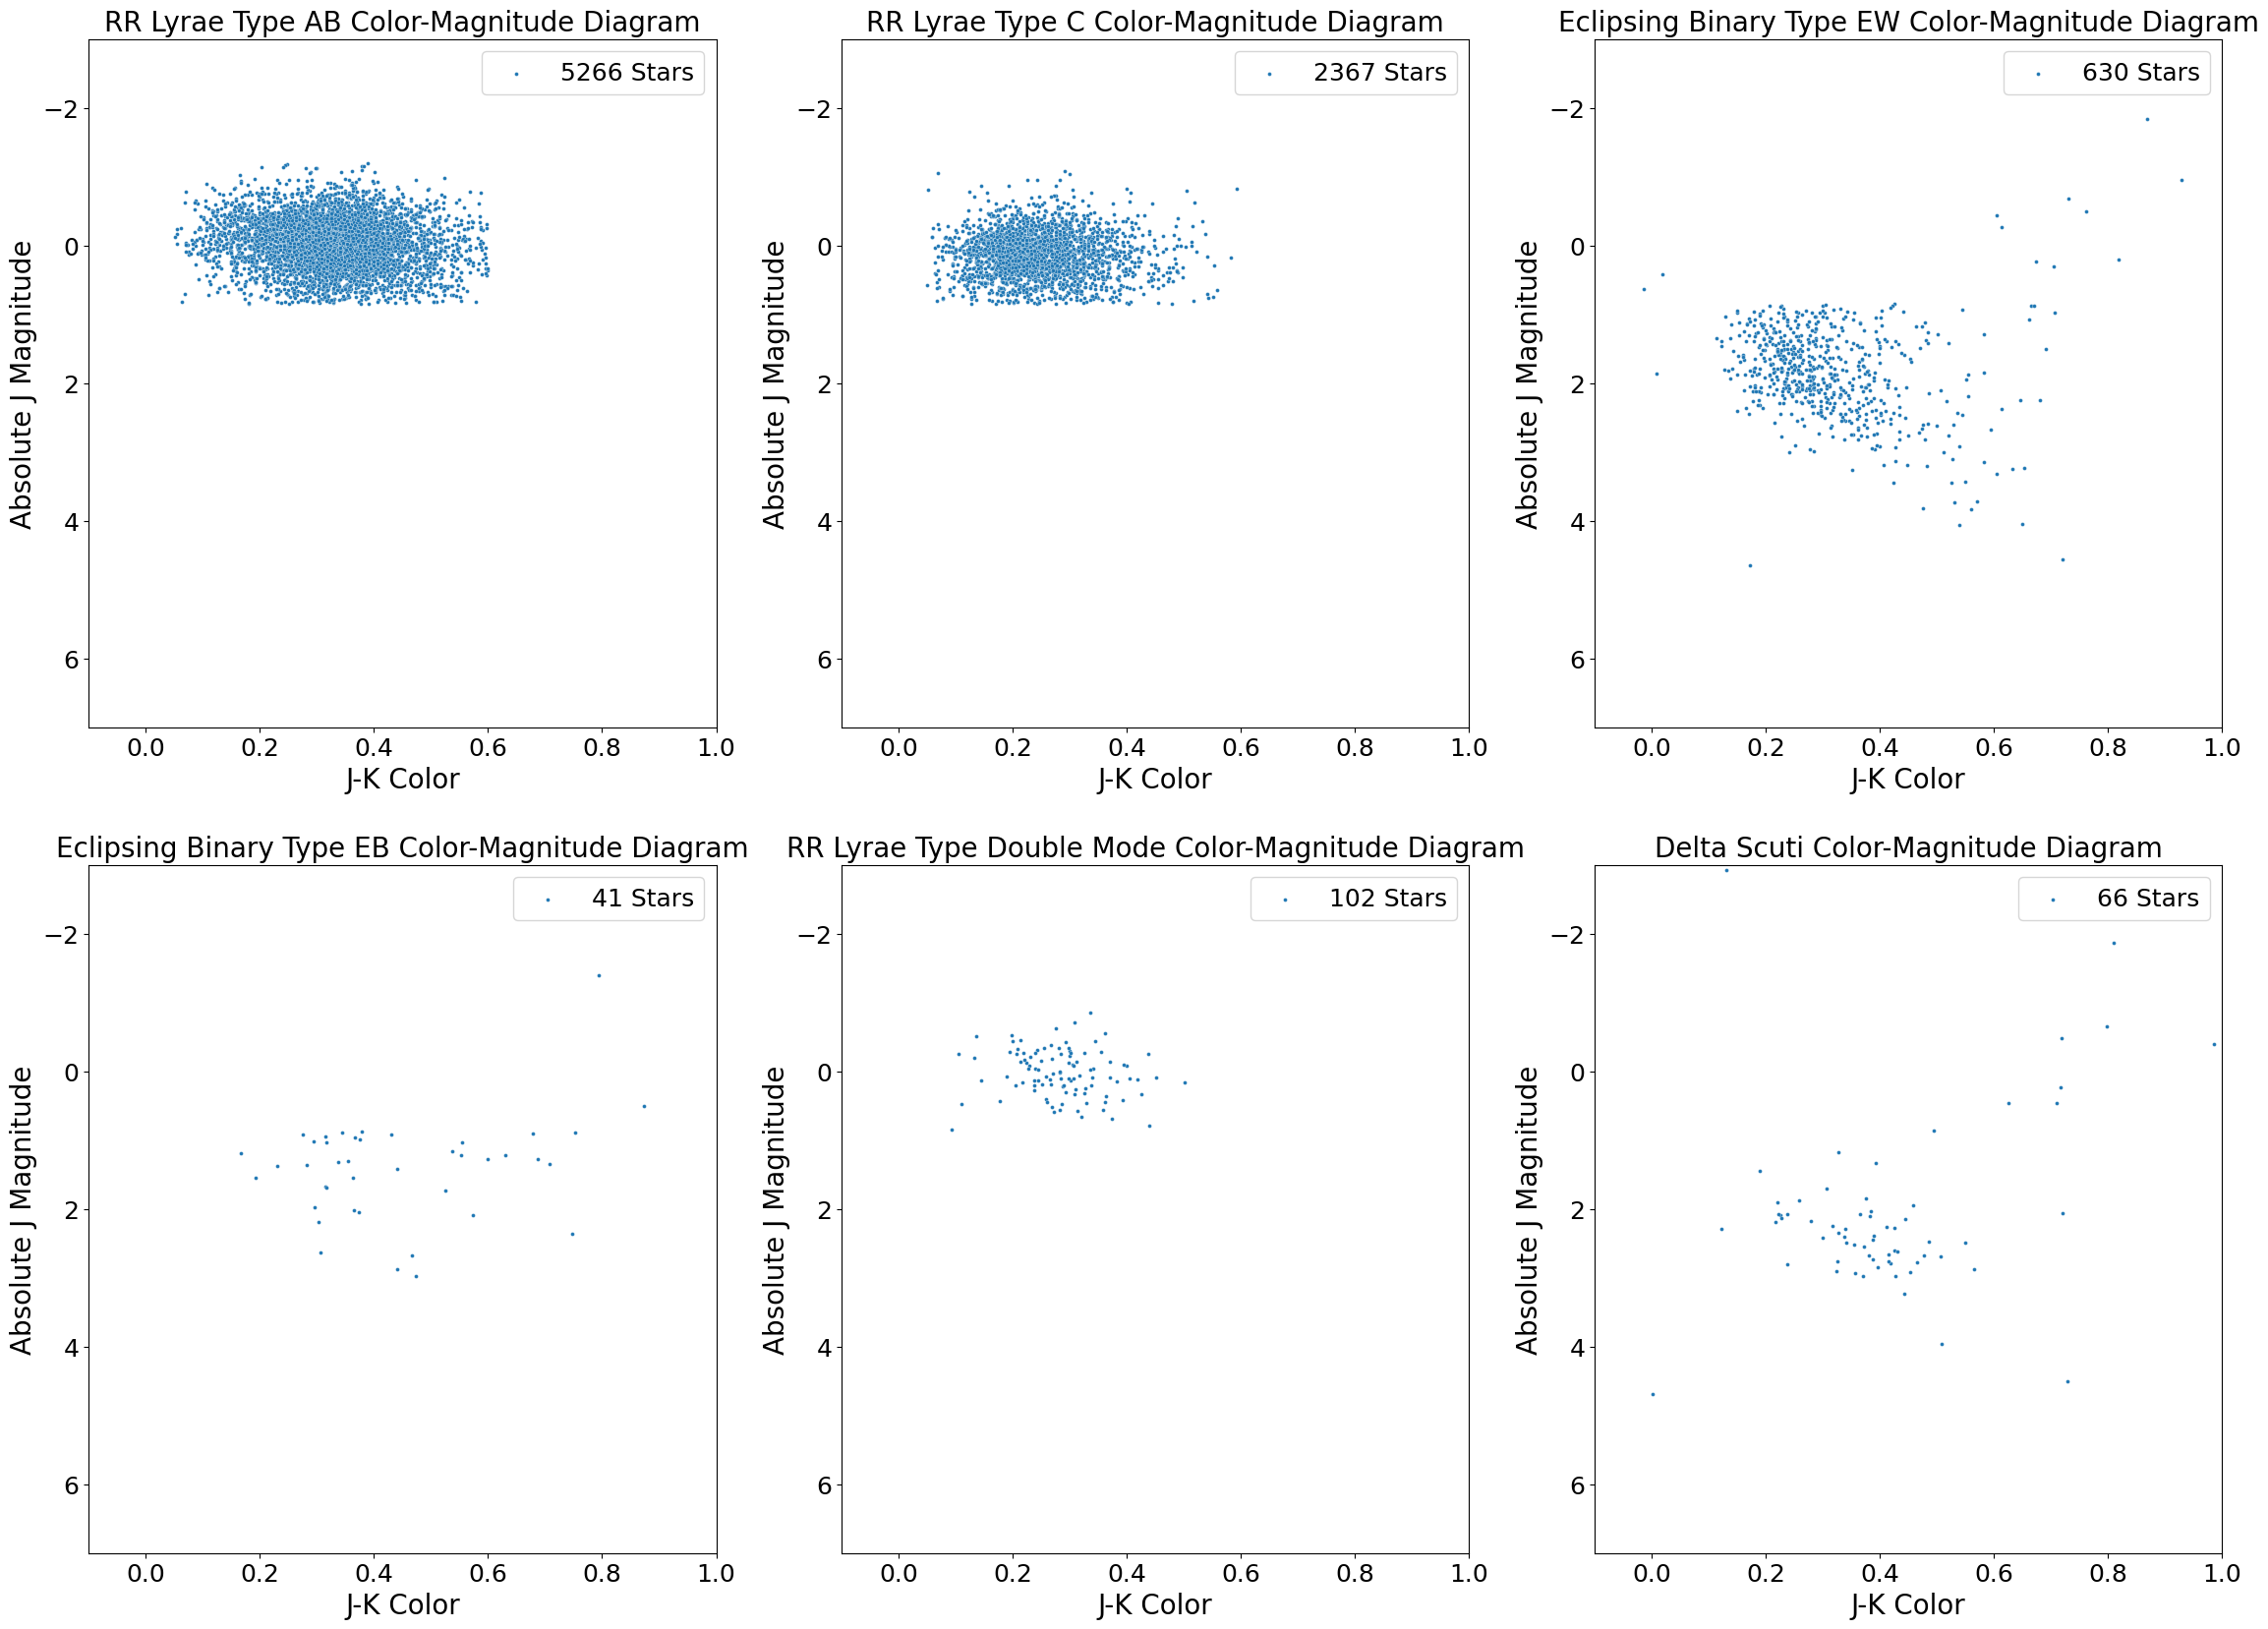

In [16]:
# plotting each remaining type in individual graphs to see where the boundaries of each region is
fig = plt.figure(figsize=(28, 20))

ax1 = fig.add_subplot(231)
sns.scatterplot(data=RRAB, x='J-K', y='abs_mag_J', s=8, label = f"{len(RRAB)} Stars")
ax1.invert_yaxis()
ax1.set_xlabel('J-K Color', size=20)
ax1.set_ylabel('Absolute J Magnitude', size=20)
ax1.set_title('RR Lyrae Type AB Color-Magnitude Diagram', size=20)
ax1.tick_params(axis='both', which='major', labelsize=18)
ax1.legend(fontsize=18)
ax1.set_xlim(-0.1, 1)
ax1.set_ylim(7, -3)

ax2 = fig.add_subplot(232)
sns.scatterplot(data=RRC, x='J-K', y='abs_mag_J', s=8, label = f"{len(RRC)} Stars")
ax2.invert_yaxis()
ax2.set_xlabel('J-K Color', size=20)
ax2.set_ylabel('Absolute J Magnitude', size=20)
ax2.set_title('RR Lyrae Type C Color-Magnitude Diagram', size=20)
ax2.tick_params(axis='both', which='major', labelsize=18)
ax2.legend(fontsize=18)
ax2.set_xlim(-0.1, 1)
ax2.set_ylim(7, -3)

ax3 = fig.add_subplot(233)
sns.scatterplot(data=EW, x='J-K', y='abs_mag_J', s=8, label = f"{len(EW)} Stars")
ax3.invert_yaxis()
ax3.set_xlabel('J-K Color', size=20)
ax3.set_ylabel('Absolute J Magnitude', size=20)
ax3.set_title('Eclipsing Binary Type EW Color-Magnitude Diagram', size=20)
ax3.tick_params(axis='both', which='major', labelsize=18)
ax3.legend(fontsize=18)
ax3.set_xlim(-0.1, 1)
ax3.set_ylim(7, -3)

ax4 = fig.add_subplot(234)
sns.scatterplot(data=EB, x='J-K', y='abs_mag_J', s=8, label = f"{len(EB)} Stars")
ax4.invert_yaxis()
ax4.set_xlabel('J-K Color', size=20)
ax4.set_ylabel('Absolute J Magnitude', size=20)
ax4.set_title('Eclipsing Binary Type EB Color-Magnitude Diagram', size=20)
ax4.tick_params(axis='both', which='major', labelsize=18)
ax4.legend(fontsize=18)
ax4.set_xlim(-0.1, 1)
ax4.set_ylim(7, -3)

ax5 = fig.add_subplot(235)
sns.scatterplot(data=RRB, x='J-K', y='abs_mag_J', s=8, label = f"{len(RRB)} Stars")
ax5.invert_yaxis()
ax5.set_xlabel('J-K Color', size=20)
ax5.set_ylabel('Absolute J Magnitude', size=20)
ax5.set_title('RR Lyrae Type Double Mode Color-Magnitude Diagram', size=20)
ax5.tick_params(axis='both', which='major', labelsize=18)
ax5.legend(fontsize=18)
ax5.set_xlim(-0.1, 1)
ax5.set_ylim(7, -3)

ax6 = fig.add_subplot(236)
sns.scatterplot(data=DSCT, x='J-K', y='abs_mag_J', s=8, label = f"{len(DSCT)} Stars")
ax6.invert_yaxis()
ax6.set_xlabel('J-K Color', size=20)
ax6.set_ylabel('Absolute J Magnitude', size=20)
ax6.set_title('Delta Scuti Color-Magnitude Diagram', size=20)
ax6.tick_params(axis='both', which='major', labelsize=18)
ax6.legend(fontsize=18)
ax6.set_xlim(-0.1, 1)
ax6.set_ylim(7, -3)

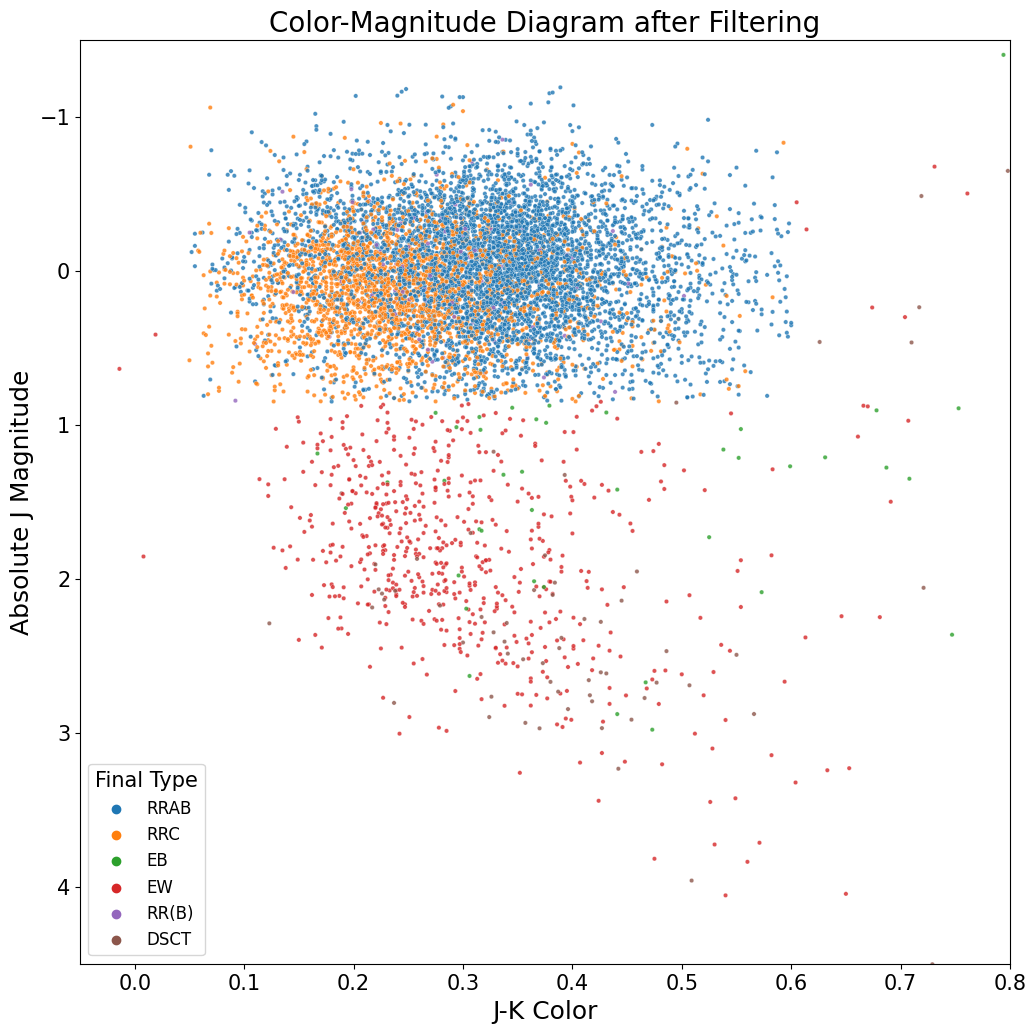

In [17]:
# combined plot
plt.figure(figsize=(12,12), dpi=100)
sns.scatterplot(data=correct_data, x='J-K', y='abs_mag_J', hue='FinalType', s=10, alpha=0.8)

plt.gca().invert_yaxis()
plt.xlabel('J-K Color', size=18)
plt.ylabel('Absolute J Magnitude', size=18)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(title="Final Type", fontsize=12, title_fontsize=15)
plt.xlim(-0.05, 0.8)
plt.ylim(4.5, -1.5)
plt.title('Color-Magnitude Diagram after Filtering', size=20)

#plt.savefig('colormag.png', format='png', dpi=1000)
plt.show()

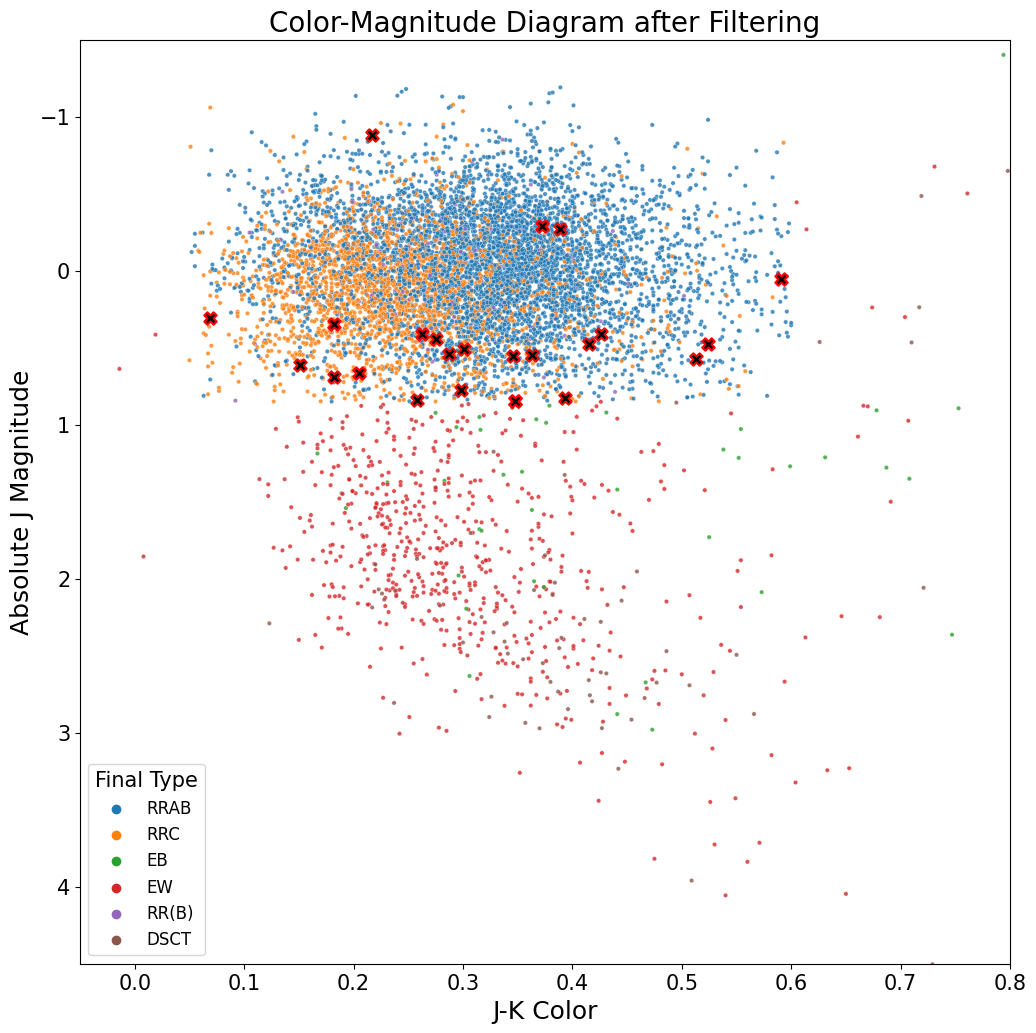

In [18]:
# List of ASASSN_IDs you want to highlight
highlight_ids = [42949677128, 25770299404, 120259254551, 60130793282, 206158828541, 17180598704, 335008534425, 137439491948, 472446951912, 292057812787, 343597911755, 309238713639, 506806729616, 266288357026, 377958233929, 420907112400, 412317673929, 575526631979, 584116631721, 532576972141, 566936206544, 395137606177, 463856556096, 644245787423]  # <-- replace with your IDs

# Create a mask for the points to highlight
highlight_points = wanted_types[wanted_types['ASASSN_id'].isin(highlight_ids)]

# Main plot
plt.figure(figsize=(12,12), dpi=100)
sns.scatterplot(data=correct_data, x='J-K', y='abs_mag_J', hue='FinalType', s=10, alpha=0.8)

plt.gca().invert_yaxis()
plt.xlabel('J-K Color', size=18)
plt.ylabel('Absolute J Magnitude', size=18)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(title="Final Type", fontsize=12, title_fontsize=15)
plt.xlim(-0.05, 0.8)
plt.ylim(4.5, -1.5)
plt.title('Color-Magnitude Diagram after Filtering', size=20)

# Overlay the highlighted points
plt.scatter(
    highlight_points['J-K'], highlight_points['abs_mag_J'],
    color='black',  # Or any color that stands out
    s=80,           # Larger size
    edgecolor='red',  # Optional: colored edge
    linewidth=1.5,
    marker='X',     # Optional: different marker like 'X' or '^'
    label='Highlighted IDs'
)